In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

Election results from OpenElections (http://openelections.net/) Shapefile from the Utah Automated Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/)

Several transcription errors were corrected from OpenElections using their raw results gathered from counties (https://github.com/openelections/openelections-sources-ut/tree/master/2018%20General%20Election). OE results in Rich and Morgan Counties were based on non-final reports, which were collected from county sources.

Emery County - 8 "canvas votes" were distributed to precincts.

Weber County - 6 precincts had their results suppressed, since all cast fewer than 15 votes, for a total of 42 votes. These were distributed based on the number of votes cast and the reported vote in 2016, which was not suppressed.

G18USSRROM - Mitt Romney (Republican Party) G18USSDWIL - Jenny Wilson (Democratic Party) G18USSIMCC - Reed C. McCandless (Independent American Party) G18USSLBOW - Craig R. Bowden (Libertarian Party) G18USSCAAL - Tim Aalders (Conservative Party) G18USSOWRI - Write-in Votes

import files

In [2]:
ut_election_results = pd.read_csv('raw-from-source/20181106__ut__general__precinct.csv')
ut_vest = gp.read_file("raw-from-source/ut_2018/ut_2018.shp")
ut_geo = gp.read_file("raw-from-source/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp")
ut_vest_2016 = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")
ut_vest_county = pd.read_csv('raw-from-source/20181106__ut__general__county.csv')

In [3]:
display(ut_geo)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0..."
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3..."
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7..."
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1..."
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589..."
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6..."
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7..."
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5..."


In [4]:
ut_senators = ut_election_results[(ut_election_results['office'] == 'U.S. Senate') | (ut_election_results['office'] == 'U S Senate')]
county_names = ut_senators['county'].unique()
print(len(county_names))
display(ut_senators)

29


,county,precinct,office,district,candidate,party,votes
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3
...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65


In [5]:
senators = (ut_senators['candidate'].unique())

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'


def find_votes(name):
    df = (ut_senators[ut_senators['candidate']== name])
    df.votes = pd.to_numeric(df.votes, errors='coerce')
    return (df[df['votes'] > 0])
    

for senator in senators:
    df = find_votes(senator)
    print(senator, 'has a total of', df.votes.sum(), 'in', len(df), 'precincts')

Tim Aalders has a total of 22190.0 in 1263 precincts
Craig Bowden has a total of 13082.0 in 888 precincts
Reed McCandless has a total of 5635.0 in 840 precincts
Jenny Wilson has a total of 142864.0 in 1331 precincts
Mitt Romney has a total of 456966.0 in 1346 precincts
write-in has a total of 721.0 in 293 precincts
MITT ROMNEY has a total of 226341 in 860 precincts
JENNY WILSON has a total of 189902 in 858 precincts
CRAIG R.  BOWDEN has a total of 9854 in 747 precincts
TIM AALDERS has a total of 7941 in 798 precincts
REED C. MCCANDLESS has a total of 4265 in 707 precincts
WRITE-IN has a total of 746 in 420 precincts
CALEB DAN REEVE has a total of 27 in 26 precincts
TYRONE JENSEN has a total of 5 in 4 precincts
GLADE G FITZGERALD has a total of 2 in 2 precincts
HEKTOR REIKSTHEGN has a total of 2 in 2 precincts
CODY JUDY has a total of 2 in 1 precincts
RYAN DANIEL JACKSON has a total of 1 in 1 precincts
ABE KORB has a total of 0 in 0 precincts
Ryan Jackson has a total of 1 in 1 precincts

In [7]:
# VEST options are: 	G18USSRROM	G18USSDWIL	G18USSIMCC	G18USSLBOW	G18USSCAAL	G18USSOWRI	
# all not in major 5 parties - write-ins
senator_dict = {
    'Tim Aalders': 'G18USSCAAL',
    'Craig Bowden': 'G18USSLBOW',
    'Reed McCandless': 'G18USSIMCC',
    'Jenny Wilson': 'G18USSDWIL',
    'Mitt Romney': 'G18USSRROM',
    'write-in': 'G18USSOWRI',
    'MITT ROMNEY': 'G18USSRROM', 
    'JENNY WILSON': 'G18USSDWIL', 
    'CRAIG R.  BOWDEN': 'G18USSLBOW', 
    'TIM AALDERS': 'G18USSCAAL', 
    'REED C. MCCANDLESS': 'G18USSIMCC', 
    'WRITE-IN': 'G18USSOWRI', 
    'CALEB DAN REEVE': 'G18USSOWRI', 
    'TYRONE JENSEN': 'G18USSOWRI', 
    'GLADE G FITZGERALD': 'G18USSOWRI', 
    'HEKTOR REIKSTHEGN': 'G18USSOWRI', 
    'CODY JUDY': 'G18USSOWRI', 
    'RYAN DANIEL JACKSON': 'G18USSOWRI', 
    'ABE KORB': 'G18USSOWRI', 
    'Ryan Jackson': 'G18USSOWRI', 
    'Craig R. Bowden': 'G18USSLBOW', 
    'Reed C. McCandless': 'G18USSIMCC', 
    'Glade G Fitzgerald (W)': 'G18USSOWRI', 
    'Caleb Dan Reeve (W)': 'G18USSOWRI', 
    'Hektor Reiksthegn (W)': 'G18USSOWRI', 
    'Abe Korb (W)': 'G18USSOWRI', 
    'Ryan Daniel Jackson (W)': 'G18USSOWRI', 
    'Cody Judy (W)': 'G18USSOWRI', 
    'Tyrone Jensen (W)': 'G18USSOWRI', 
    'Write In': 'G18USSOWRI', 
    'Write-In Totals': 'G18USSOWRI', 
    'write-ins': 'G18USSOWRI', 
    'Write-In Total': 'G18USSOWRI', 
    'CRAIG R. BOWDEN': 'G18USSLBOW', 
    'REED C. McCANDLESS': 'G18USSIMCC', 
    'Write-ins': 'G18USSOWRI', 
    'Write-In': 'G18USSOWRI', 
    'CRAIG R BOWDEN': 'G18USSLBOW', 
    'REED C MCCANDLESS': 'G18USSIMCC', 
    'Caleb Dan Reeve': 'G18USSOWRI', 
    'Write-In Votes': 'G18USSOWRI'
}


In [8]:
counties = ut_vest_2016['county'].unique()
county_name_to_num = {}
for county in counties:
    if county not in county_name_to_num:
        county_name_to_num[county] = ut_vest_2016[ut_vest_2016['county'] == county].iloc[0]['CountyID']

    
county_num_to_name = {v: k for k, v in county_name_to_num.items()}
print(county_name_to_num)
print(len(county_num_to_name))
print(county_num_to_name)
print(len(county_num_to_name))

{'Beaver': 1, 'Box Elder': 2, 'Cache': 3, 'Carbon': 4, 'Daggett': 5, 'Davis': 6, 'Emery': 8, 'Garfield': 9, 'Iron': 11, 'Kane': 13, 'Millard': 14, 'Morgan': 15, 'Piute': 16, 'Rich': 17, 'San Juan': 19, 'Sanpete': 20, 'Sevier': 21, 'Summit': 22, 'Uintah': 24, 'Wayne': 28, 'Grand': 10, 'Juab': 12, 'Salt Lake': 18, 'Tooele': 23, 'Utah': 25, 'Wasatch': 26, 'Washington': 27, 'Weber': 29, 'Duchesne': 7}
29
{1: 'Beaver', 2: 'Box Elder', 3: 'Cache', 4: 'Carbon', 5: 'Daggett', 6: 'Davis', 8: 'Emery', 9: 'Garfield', 11: 'Iron', 13: 'Kane', 14: 'Millard', 15: 'Morgan', 16: 'Piute', 17: 'Rich', 19: 'San Juan', 20: 'Sanpete', 21: 'Sevier', 22: 'Summit', 24: 'Uintah', 28: 'Wayne', 10: 'Grand', 12: 'Juab', 18: 'Salt Lake', 23: 'Tooele', 25: 'Utah', 26: 'Wasatch', 27: 'Washington', 29: 'Weber', 7: 'Duchesne'}
29


In [9]:
ut_senators['countyid'] = ut_senators['county'].map(county_name_to_num)
display(ut_senators)

,county,precinct,office,district,candidate,party,votes,countyid
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7,28
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6,28
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6,28
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8,28
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3,28
...,...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4,15
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0,15
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6,15
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65,15


In [182]:
def cast_to_int(num):
    if num != '*':
        return int(num)
    else:
        return '*'

ut_senators['mergeid'] = ut_senators['countyid'].astype(str)+'-'+ut_senators['precinct']
ut_senators['candidateid'] = ut_senators['candidate'].map(senator_dict)
ut_senators['votes'] = ut_senators['votes'].apply(cast_to_int)
display(ut_senators)


,county,precinct,office,district,candidate,party,votes,countyid,mergeid,candidateid
0,Wayne,Fremont,U.S. Senate,NaN,Tim Aalders,Con,7,28,28-Fremont,G18USSCAAL
1,Wayne,Loa in/out,U.S. Senate,NaN,Tim Aalders,Con,6,28,28-Loa in/out,G18USSCAAL
2,Wayne,Lyman in/out,U.S. Senate,NaN,Tim Aalders,Con,6,28,28-Lyman in/out,G18USSCAAL
3,Wayne,Bicknell in/out,U.S. Senate,NaN,Tim Aalders,Con,8,28,28-Bicknell in/out,G18USSCAAL
4,Wayne,Teesdale,U.S. Senate,NaN,Tim Aalders,Con,3,28,28-Teesdale,G18USSCAAL
...,...,...,...,...,...,...,...,...,...,...
41987,Morgan,Croydon 15.5,U S Senate,NaN,Craig R. Bowden,LIB,4,15,15-Croydon 15.5,G18USSLBOW
41988,Morgan,Croydon 15.5,U S Senate,NaN,Reed C. McCandless,IAP,0,15,15-Croydon 15.5,G18USSIMCC
41989,Morgan,Croydon 15.5,U S Senate,NaN,Jenny Wilson,DEM,6,15,15-Croydon 15.5,G18USSDWIL
41990,Morgan,Croydon 15.5,U S Senate,NaN,Mitt Romney,REP,65,15,15-Croydon 15.5,G18USSRROM


In [233]:
pivoted_2018 = pd.pivot_table(ut_senators,values=["votes"],index=["mergeid"],columns=["candidateid"],aggfunc=sum)
pivoted_2018=pivoted_2018.fillna(0)
pivoted_2018.reset_index(drop=False,inplace=True)
#pivoted_2018.columns = pivoted_2018.columns.droplevel(0)

pivoted_2018.columns = ['joinid', 'G18USSCAAL', 'G18USSDWIL', 'G18USSIMCC', 'G18USSLBOW', 'G18USSOWRI', 'G18USSRROM']
display(pivoted_2018)
pivoted_2018.to_csv('./pivoted_2018.csv')

,joinid,G18USSCAAL,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSOWRI,G18USSRROM
0,1-Beaver 1,19,46,8,9,1,402
1,1-Beaver 2,17,46,3,10,0,310
2,1-Beaver 3,12,30,0,2,2,244
3,1-Beaver 4,23,7,1,4,0,84
4,1-Greenville,1,9,6,1,1,56
...,...,...,...,...,...,...,...
2266,9-Henrieville HE6:1,3,14,0,2,0,94
2267,9-Panguitch 1 PA7:1,18,37,3,12,0,374
2268,9-Panguitch 2 PA8:1,11,28,4,2,0,315
2269,9-Ticaboo TI9:1,0,4,0,1,0,10


In [234]:
display(ut_vest)

,CountyID,mergeid,uniqueid,G18USSRROM,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSCAAL,G18USSOWRI,geometry,joinid
0,1,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01
1,1,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02
2,1,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03
3,1,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04
4,1,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01
...,...,...,...,...,...,...,...,...,...,...,...
2332,27,COUN06,27-COUN06,0,0,0,0,0,0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06
2333,27,COUN07,27-COUN07,0,0,0,0,0,0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07
2334,27,SGAIR,27-SGAIR,0,0,0,0,0,0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR
2335,29,LAKE,29-LAKE,0,0,0,0,0,0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE


In [235]:
ut_vest['joinid'] = ut_vest['CountyID'].astype(str)+'-'+ut_vest['mergeid']
display(ut_vest)
display(ut_vest[ut_vest['uniqueid'] == '2-BRE'])

,CountyID,mergeid,uniqueid,G18USSRROM,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSCAAL,G18USSOWRI,geometry,joinid
0,1,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01
1,1,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02
2,1,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03
3,1,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04
4,1,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01
...,...,...,...,...,...,...,...,...,...,...,...
2332,27,COUN06,27-COUN06,0,0,0,0,0,0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06
2333,27,COUN07,27-COUN07,0,0,0,0,0,0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07
2334,27,SGAIR,27-SGAIR,0,0,0,0,0,0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR
2335,29,LAKE,29-LAKE,0,0,0,0,0,0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE


,CountyID,mergeid,uniqueid,G18USSRROM,G18USSDWIL,G18USSIMCC,G18USSLBOW,G18USSCAAL,G18USSOWRI,geometry,joinid
27,2,BRE,2-BRE,159,31,6,6,13,0,"POLYGON ((408054.500 4607600.010, 409656.080 4...",2-BRE


In [238]:
join_attempt_one = pd.merge(ut_vest,pivoted_2018,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv("./merged_votes.csv")

both          1693
left_only      644
right_only     578
Name: _merge, dtype: int64


In [239]:
#3-LOG37-CSD	3-LOG27:CSD
#22-Lower Silver Creek	22-SCRL44

In [240]:
joinid = pd.read_csv('joinid_dict.csv')

In [241]:
display(joinid)

,source_joinid,vest_joinid,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1-Beaver 1,1-BV01,NaN,NaN,NaN,NaN,NaN
1,1-Beaver 2,1-BV02,NaN,NaN,NaN,NaN,NaN
2,1-Beaver 3,1-BV03,NaN,NaN,NaN,NaN,NaN
3,1-Beaver 4,1-BV04,NaN,NaN,NaN,NaN,NaN
4,1-Greenville,1-GR01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
650,NaN,27-COUN06,NaN,NaN,NaN,NaN,NaN
651,NaN,27-COUN07,NaN,NaN,NaN,NaN,NaN
652,NaN,27-SGAIR,NaN,NaN,NaN,NaN,NaN
653,NaN,29-LAKE,NaN,NaN,NaN,NaN,NaN


In [242]:
joinid_dict = dict(zip(joinid["source_joinid"],joinid["vest_joinid"]))
pivoted_2018["joinid"] = pivoted_2018["joinid"].map(joinid_dict).fillna(pivoted_2018["joinid"])

In [245]:
#filter out totals before join

join_attempt_one = pd.merge(ut_vest,pivoted_2018,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())


merged = join_attempt_one[join_attempt_one["_merge"]=="both"]
right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv('./merged2.csv')

both          2260
left_only       77
right_only      11
Name: _merge, dtype: int64


In [246]:
display(merged)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge
0,1.0,BV01,1-BV01,402.0,46.0,8.0,9.0,19.0,1.0,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both
1,1.0,BV02,1-BV02,310.0,46.0,3.0,10.0,17.0,0.0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both
2,1.0,BV03,1-BV03,244.0,30.0,0.0,2.0,12.0,2.0,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both
3,1.0,BV04,1-BV04,84.0,7.0,1.0,4.0,23.0,0.0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both
4,1.0,GR01,1-GR01,56.0,9.0,6.0,1.0,1.0,1.0,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,29.0,WHV007,29-WHV007,336.0,96.0,3.0,11.0,20.0,3.0,"POLYGON ((414078.060 4566073.720, 414078.500 4...",29-WHV007,20,96,3,11,3,336,both
2257,29.0,WHV008,29-WHV008,90.0,46.0,6.0,9.0,10.0,1.0,"POLYGON ((414331.410 4566096.430, 414338.050 4...",29-WHV008,10,46,6,9,1,90,both
2258,29.0,WNO001,29-WNO001,1.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,*,8,*,*,*,*,both
2259,29.0,WNO002,29-WNO002,7.0,1.0,0.0,1.0,2.0,0.0,"MULTIPOLYGON (((420125.050 4572851.460, 420130...",29-WNO002,*,*,*,*,*,*,both


In [247]:

display(left_only)
display(right_only)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge
60,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2261,3.0,UNINH,3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((435554.350 4631146.260, 435550...",3-UNINH,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2262,3.0,UNINHC,3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((432646.560 4619810.180, 432640.360 4...",3-UNINHC,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2263,6.0,DC01,6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((402321.480 4549317.100, 402716.900 4...",6-DC01,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2264,6.0,DC02,6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((405054.200 4554496.340, 405072.690 4...",6-DC02,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,NaN,NaN,NaN,NaN,NaN,NaN,left_only


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge
2337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,11-IRON UT,866,2846,206,597,68,11286,right_only
2338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,13-TOTALS,109,746,38,89,6,2135,right_only
2339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,21-TOTALS,408,771,113,173,50,5810,right_only
2340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-AF11:UN,0,0,0,0,0,0,right_only
2341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-CH02:UN,0,0,0,0,0,0,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-MA05:UN,0,0,0,0,0,0,right_only
2344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SP09:UN,0,0,0,0,0,0,right_only
2345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SP14:UN,0,0,0,0,0,0,right_only
2346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25-SR08:UN,0,0,0,0,0,0,right_only


In [248]:

print(left_only.mergeid.unique())

['WLRD' 'UNINH' 'UNINHC' 'DC01' 'DC02' 'DC03' 'DC04' '13' 'NE03:5'
 'DRP005' 'NLC001' 'NRV001' 'NRV002' 'NRV003' 'NRV004' 'NRV005' 'NRV006'
 'NRV007' 'NRV008' 'NRV009' 'NRV010' 'NRV011' 'NRV013' 'NRV014' 'NRV015'
 'NRV016' 'NRV017' 'NRV018' 'NRV019' 'NRV020' 'NRV022' 'NRV024' 'NRV025'
 'NRV026' 'NRV028' 'NRV029' 'NRV030' 'NRV031' 'NRV033' 'NRV034' 'NRV035'
 'NRV037' 'NRV040' 'NRV045' 'NRV046' 'NRV047' 'NRV050' 'NRV051' 'NRV052'
 'NRV053' 'NRV054' 'NRV055' 'NRV056' 'NRV057' 'NRV060' 'NRV061' 'NRV062'
 'NRV063' 'NRV067' 'NRV069' 'NRV071' 'SAN088' 'SLC154' 'SNB002' 'SR09:UN'
 'SR10:UN' 'COUN01' 'COUN02' 'COUN03' 'COUN04' 'COUN05' 'COUN06' 'COUN07'
 'SGAIR' 'LAKE' 'UNKN']


In [249]:
def is_non_empty_row_left(row):
    if row['G18USSRROM_x'] != 0 \
    or row['G18USSDWIL_x'] != 0 \
    or row['G18USSIMCC_x'] != 0 \
    or row['G18USSLBOW_x'] != 0 \
    or row['G18USSCAAL_x'] != 0 \
    or row['G18USSOWRI_x'] != 0:
        return True

def is_non_empty_row_right(row):
    if row['G18USSRROM_y'] != 0 \
    or row['G18USSDWIL_y'] != 0 \
    or row['G18USSIMCC_y'] != 0 \
    or row['G18USSLBOW_y'] != 0 \
    or row['G18USSCAAL_y'] != 0 \
    or row['G18USSOWRI_y'] != 0:
        return True

In [250]:
left_only['totals'] = (
    left_only['G18USSRROM_x'] + left_only['G18USSDWIL_x'] + 
    left_only['G18USSIMCC_x'] + left_only['G18USSLBOW_x'] + 
    left_only['G18USSCAAL_x'] + left_only['G18USSOWRI_x']
)
vest_non_zero = left_only[left_only['totals'] != 0]
display(vest_non_zero)


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
60,2.0,WLRD,2-WLRD,609.0,126.0,13.0,11.0,26.0,5.0,"POLYGON ((387979.000 4593096.400, 388079.300 4...",2-WLRD,NaN,NaN,NaN,NaN,NaN,NaN,left_only,790.0


In [251]:
zero_vote_precincts = left_only.drop(vest_non_zero.index)
display(zero_vote_precincts)
#since all these precincts have zero votes and only exist within vest
#we can manually set these to have zero votes in the election data dataframe
list_of_candidates = ['G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']
for cand in list_of_candidates:
    zero_vote_precincts[cand] = '0'
zero_vote_precincts['_merge'] = 'both'
display(zero_vote_precincts)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2261,3.0,UNINH,3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((435554.350 4631146.260, 435550...",3-UNINH,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2262,3.0,UNINHC,3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((432646.560 4619810.180, 432640.360 4...",3-UNINHC,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2263,6.0,DC01,6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((402321.480 4549317.100, 402716.900 4...",6-DC01,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2264,6.0,DC02,6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((405054.200 4554496.340, 405072.690 4...",6-DC02,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2265,6.0,DC03,6-DC03,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((423330.200 4540532.600, 423303.210 4...",6-DC03,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,NaN,NaN,NaN,NaN,NaN,NaN,left_only,0.0


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2261,3.0,UNINH,3-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((435554.350 4631146.260, 435550...",3-UNINH,0,0,0,0,0,0,both,0.0
2262,3.0,UNINHC,3-UNINHC,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((432646.560 4619810.180, 432640.360 4...",3-UNINHC,0,0,0,0,0,0,both,0.0
2263,6.0,DC01,6-DC01,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((402321.480 4549317.100, 402716.900 4...",6-DC01,0,0,0,0,0,0,both,0.0
2264,6.0,DC02,6-DC02,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((405054.200 4554496.340, 405072.690 4...",6-DC02,0,0,0,0,0,0,both,0.0
2265,6.0,DC03,6-DC03,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((423330.200 4540532.600, 423303.210 4...",6-DC03,0,0,0,0,0,0,both,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,0,0,0,0,0,0,both,0.0
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,0,0,0,0,0,0,both,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0,0,0,0,0,0,both,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0,0,0,0,0,0,both,0.0


In [252]:
right_only['totals'] = (
    right_only['G18USSRROM_y'].astype(int) + right_only['G18USSDWIL_y'].astype(int) + 
    right_only['G18USSIMCC_y'].astype(int) + right_only['G18USSLBOW_y'].astype(int) + 
    right_only['G18USSCAAL_y'].astype(int) + right_only['G18USSOWRI_y'].astype(int)
)
sos_non_zero = right_only[right_only['totals'] != 0]
display(sos_non_zero)
    



,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,11-IRON UT,866,2846,206,597,68,11286,right_only,15869
2338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,13-TOTALS,109,746,38,89,6,2135,right_only,3123
2339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,21-TOTALS,408,771,113,173,50,5810,right_only,7325
2347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8-Canvas,1,1,0,0,0,6,right_only,8


In [253]:
merged_with_zero_left_vote = pd.concat([merged, zero_vote_precincts])
display(merged_with_zero_left_vote)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
0,1.0,BV01,1-BV01,402.0,46.0,8.0,9.0,19.0,1.0,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both,NaN
1,1.0,BV02,1-BV02,310.0,46.0,3.0,10.0,17.0,0.0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both,NaN
2,1.0,BV03,1-BV03,244.0,30.0,0.0,2.0,12.0,2.0,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both,NaN
3,1.0,BV04,1-BV04,84.0,7.0,1.0,4.0,23.0,0.0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both,NaN
4,1.0,GR01,1-GR01,56.0,9.0,6.0,1.0,1.0,1.0,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,0,0,0,0,0,0,both,0.0
2333,27.0,COUN07,27-COUN07,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,0,0,0,0,0,0,both,0.0
2334,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0,0,0,0,0,0,both,0.0
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0,0,0,0,0,0,both,0.0


In [289]:
pd.set_option('display.max_rows', 10)

display(merged_with_zero_left_vote)
test_county = (merged_with_zero_left_vote[merged_with_zero_left_vote['CountyID'] == 18])
display(test_county)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
0,1.0,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both,NaN
1,1.0,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both,NaN
2,1.0,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both,NaN
3,1.0,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both,NaN
4,1.0,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,27.0,COUN06,27-COUN06,0,0,0,0,0,0,"POLYGON ((255057.190 4154374.220, 256665.370 4...",27-COUN06,0,0,0,0,0,0,both,0.0
2333,27.0,COUN07,27-COUN07,0,0,0,0,0,0,"POLYGON ((284912.790 4113292.470, 284905.170 4...",27-COUN07,0,0,0,0,0,0,both,0.0
2334,27.0,SGAIR,27-SGAIR,0,0,0,0,0,0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0,0,0,0,0,0,both,0.0
2335,29.0,LAKE,29-LAKE,0,0,0,0,0,0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0,0,0,0,0,0,both,0.0


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
595,18.0,ALT001,18-ALT001,24,99,1,3,1,0,"POLYGON ((447709.960 4494899.800, 447737.330 4...",18-ALT001,1,99,1,3,0,24,both,NaN
596,18.0,BLF001,18-BLF001,735,148,13,29,26,0,"POLYGON ((417236.870 4483768.860, 419204.190 4...",18-BLF001,26,148,13,29,0,735,both,NaN
597,18.0,BLF003,18-BLF003,687,232,8,22,26,3,"POLYGON ((421262.720 4483724.930, 421261.850 4...",18-BLF003,26,232,8,22,3,687,both,NaN
598,18.0,BLF004,18-BLF004,696,128,4,20,23,0,"POLYGON ((419632.660 4482528.440, 419600.830 4...",18-BLF004,23,128,4,20,0,696,both,NaN
599,18.0,BLF005,18-BLF005,15,4,0,0,3,0,"POLYGON ((422048.120 4483316.950, 422048.080 4...",18-BLF005,3,4,0,0,0,15,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,18.0,NRV069,18-NRV069,0,0,0,0,0,0,"POLYGON ((427542.050 4496177.060, 427538.290 4...",18-NRV069,0,0,0,0,0,0,both,0.0
2321,18.0,NRV071,18-NRV071,0,0,0,0,0,0,"POLYGON ((427563.660 4495772.200, 427531.790 4...",18-NRV071,0,0,0,0,0,0,both,0.0
2322,18.0,SAN088,18-SAN088,0,0,0,0,0,0,"POLYGON ((426191.040 4491382.400, 426318.420 4...",18-SAN088,0,0,0,0,0,0,both,0.0
2323,18.0,SLC154,18-SLC154,0,0,0,0,0,0,"POLYGON ((428876.800 4507890.150, 428846.060 4...",18-SLC154,0,0,0,0,0,0,both,0.0


In [257]:
races = ['G18USSCAAL_x','G18USSDWIL_x','G18USSIMCC_x','G18USSLBOW_x','G18USSOWRI_x','G18USSRROM_x','G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']

for race in races:
    merged_with_zero_left_vote[race] = merged_with_zero_left_vote[race].apply(cast_to_int)


In [290]:
#canvas votes for county 8 distributed

#change vote distribution when validating with totals

canvas_votes = sos_non_zero[sos_non_zero["joinid"] ==  '8-Canvas']
office_rom = canvas_votes["G18USSRROM_y"].iloc[0]
office_wil = canvas_votes["G18USSDWIL_y"].iloc[0]
office_aal = canvas_votes["G18USSCAAL_y"].iloc[0]

display(canvas_votes)

ut_precinct_8 = merged_with_zero_left_vote[merged_with_zero_left_vote['CountyID'] == 8]

merged_distribute = merged_with_zero_left_vote.drop(ut_precinct_8.index)

display(ut_precinct_8)

ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSRROM_y', ascending=False)
for i in range(0, int(office_rom)):
    ut_precinct_8['G18USSRROM_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSRROM_y']) + 1)
    
display(ut_precinct_8) 
    
ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSDWIL_y', ascending=False)
for i in range(0, int(office_wil)):
    ut_precinct_8['G18USSDWIL_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSDWIL_y']) + 1)

ut_precinct_8 = ut_precinct_8.sort_values(by = 'G18USSCAAL_y', ascending=False)
for i in range(0, int(office_aal)):
    ut_precinct_8['G18USSCAAL_y'].iloc[i] = str(int(ut_precinct_8.iloc[i]['G18USSCAAL_y']) + 1)

display(ut_precinct_8)

merged_with_canvas = pd.concat([merged_distribute, ut_precinct_8])
display(merged_with_canvas)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8-Canvas,1,1,0,0,0,6,right_only,8


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,296,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN
441,8.0,12,8-12,239,58,10,4,14,1,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,13,58,10,4,1,238,both,NaN
442,8.0,2,8-2,307,32,16,6,7,1,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,307,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
447,8.0,7,8-7,269,45,6,8,6,1,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,268,both,NaN
448,8.0,8,8-8,330,55,20,9,12,0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,329,both,NaN
449,8.0,9,8-9,306,59,24,8,8,0,"MULTIPOLYGON (((487237.900 4384014.260, 487235...",8-9,8,59,24,8,0,305,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
448,8.0,8,8-8,330,55,20,9,12,0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,330,both,NaN
442,8.0,2,8-2,307,32,16,6,7,1,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,308,both,NaN
449,8.0,9,8-9,306,59,24,8,8,0,"MULTIPOLYGON (((487237.900 4384014.260, 487235...",8-9,8,59,24,8,0,306,both,NaN
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
447,8.0,7,8-7,269,45,6,8,6,1,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
444,8.0,4,8-4,80,12,5,2,5,0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,80,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
441,8.0,12,8-12,239,58,10,4,14,1,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,14,58,10,4,1,238,both,NaN
448,8.0,8,8-8,330,55,20,9,12,0,"POLYGON ((501561.880 4368910.840, 501926.760 4...",8-8,12,55,20,9,0,330,both,NaN
449,8.0,9,8-9,306,59,24,8,8,0,"MULTIPOLYGON (((487237.900 4384014.260, 487235...",8-9,8,60,24,8,0,306,both,NaN
443,8.0,3,8-3,234,54,21,6,7,1,"POLYGON ((486406.990 4340463.060, 486466.980 4...",8-3,7,54,21,6,1,234,both,NaN
440,8.0,11,8-11,178,36,14,7,7,0,"POLYGON ((523993.020 4368901.080, 523993.420 4...",8-11,7,36,14,7,0,178,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
444,8.0,4,8-4,80,12,5,2,5,0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,80,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
0,1.0,BV01,1-BV01,402,46,8,9,19,1,"POLYGON ((358362.560 4238423.840, 358372.350 4...",1-BV01,19,46,8,9,1,402,both,NaN
1,1.0,BV02,1-BV02,310,46,3,10,17,0,"POLYGON ((355866.750 4240506.080, 356860.230 4...",1-BV02,17,46,3,10,0,310,both,NaN
2,1.0,BV03,1-BV03,244,30,0,2,12,2,"POLYGON ((358902.400 4261055.000, 358909.700 4...",1-BV03,12,30,0,2,2,244,both,NaN
3,1.0,BV04,1-BV04,84,7,1,4,23,0,"POLYGON ((367866.500 4262536.100, 367842.500 4...",1-BV04,23,7,1,4,0,84,both,NaN
4,1.0,GR01,1-GR01,56,9,6,1,1,1,"POLYGON ((348977.460 4223848.220, 348973.090 4...",1-GR01,1,9,6,1,1,56,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,8.0,10,8-10,297,43,11,10,6,0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,both,NaN
446,8.0,6,8-6,222,39,14,4,5,0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,both,NaN
438,8.0,1,8-1,109,16,7,2,5,0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,both,NaN
444,8.0,4,8-4,80,12,5,2,5,0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,80,both,NaN


In [291]:
#recreate finding 42 votes in weber using totals
#for each column - add up votes and see if they are equal
#unfilter the vest 2016 results, eyeball if any other race correlate with vote ratios
#if no other 2 parties are available -> use total pop per precinct to assign votes

suppressed_precincts = pre_suppress.loc[(pre_suppress["G18USSCAAL_y"] == '*') |
                 (pre_suppress["G18USSDWIL_y"] == '*') |
                (pre_suppress["G18USSIMCC_y"] == '*') |
                (pre_suppress["G18USSLBOW_y"] == '*') |
                (pre_suppress["G18USSOWRI_y"] == '*') |
                (pre_suppress["G18USSRROM_y"] == '*')]

display(suppressed_precincts)

suppressed_ids = suppressed_precincts.mergeid.unique()

print(suppressed_ids)

vest_2016_weber = (ut_vest_2016[ut_vest_2016['CountyID'] == 29])
vest_2016_suppress = (vest_2016_weber[vest_2016_weber['PrecinctID'].isin(suppressed_ids)])
vest_2016_senators = ['G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR']
vest_2016_basic_columns = ['CountyID','PrecinctID','county','precinct']
vest_2016_columns = vest_2016_basic_columns + vest_2016_senators
vest_2016_suppress = vest_2016_suppress[vest_2016_columns]
display(vest_2016_suppress)



,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2240,29.0,WCO001,29-WCO001,9.0,3.0,0.0,1.0,1.0,0.0,"MULTIPOLYGON (((414060.530 4562442.630, 414102...",29-WCO001,*,*,*,*,*,*,both,NaN
2243,29.0,WCR002,29-WCR002,2.0,7.0,1.0,1.0,1.0,0.0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,*,*,*,*,*,*,both,NaN
2244,29.0,WCS001,29-WCS001,1.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,*,*,*,*,*,*,both,NaN
2247,29.0,WCV001,29-WCV001,1.0,1.0,0.0,1.0,0.0,0.0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,*,*,*,*,*,*,both,NaN
2258,29.0,WNO001,29-WNO001,1.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,*,8,*,*,*,*,both,NaN
2259,29.0,WNO002,29-WNO002,7.0,1.0,0.0,1.0,2.0,0.0,"MULTIPOLYGON (((420125.050 4572851.460, 420130...",29-WNO002,*,*,*,*,*,*,both,NaN


['WCO001' 'WCR002' 'WCS001' 'WCV001' 'WNO001' 'WNO002']


,CountyID,PrecinctID,county,precinct,G16USSRLEE,G16USSDSNO,G16USSAFON,G16USSIBAR
2240,29,WCO001,Weber,WCO001,12,2,1,0
2243,29,WCR002,Weber,WCR002,9,11,0,0
2245,29,WCS001,Weber,WCS001,2,0,0,0
2248,29,WCV001,Weber,WCV001,2,0,0,0
2259,29,WNO001,Weber,WNO001,8,1,0,0
2260,29,WNO002,Weber,WNO002,18,0,0,0


In [292]:
weber = (pre_suppress[pre_suppress['CountyID'] == 29])
non_suppress = weber.drop(suppressed_precincts.index)
display(non_suppress)
print(non_suppress['G18USSRROM_y'].astype(int).sum())
display(ut_vest_county[(ut_vest_county['county'] == 'Weber') & (ut_vest_county['office'] == 'U.S. Senate')])

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2103,29.0,CYN001,29-CYN001,37.0,53.0,2.0,6.0,3.0,0.0,"POLYGON ((429767.380 4567616.890, 429752.330 4...",29-CYN001,3,53,2,6,0,37,both,NaN
2104,29.0,FRW001,29-FRW001,476.0,79.0,3.0,11.0,18.0,1.0,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,both,NaN
2105,29.0,FRW002,29-FRW002,304.0,132.0,5.0,12.0,24.0,1.0,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,both,NaN
2106,29.0,FRW003,29-FRW003,583.0,129.0,11.0,29.0,24.0,3.0,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,both,NaN
2107,29.0,FRW004,29-FRW004,652.0,143.0,12.0,35.0,32.0,2.0,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,29.0,WHV007,29-WHV007,336.0,96.0,3.0,11.0,20.0,3.0,"POLYGON ((414078.060 4566073.720, 414078.500 4...",29-WHV007,20,96,3,11,3,336,both,NaN
2257,29.0,WHV008,29-WHV008,90.0,46.0,6.0,9.0,10.0,1.0,"POLYGON ((414331.410 4566096.430, 414338.050 4...",29-WHV008,10,46,6,9,1,90,both,NaN
2260,29.0,WNO003,29-WNO003,24.0,17.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((419849.820 4571401.230, 419849...",29-WNO003,0,17,0,0,0,24,both,NaN
2335,29.0,LAKE,29-LAKE,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((431658.370 4571461.460, 431647.750 4...",29-LAKE,0,0,0,0,0,0,both,0.0


49337


,county,office,district,party,candidate,votes
28,Weber,U.S. Senate,NaN,LIB,Craig R. Bowden,2691
57,Weber,U.S. Senate,NaN,DEM,Jenny Wilson,24513
86,Weber,U.S. Senate,NaN,REP,Mitt Romney,49458
115,Weber,U.S. Senate,NaN,IAP,Reed C. McCandless,1080
144,Weber,U.S. Senate,NaN,CON,Tim Aalders,2443


In [293]:
test_county = (pre_suppress[pre_suppress['CountyID'] == 18])
display(test_county)

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
595,18.0,ALT001,18-ALT001,24.0,99.0,1.0,3.0,1.0,0.0,"POLYGON ((447709.960 4494899.800, 447737.330 4...",18-ALT001,1,99,1,3,00000000,24,both,NaN
596,18.0,BLF001,18-BLF001,735.0,148.0,13.0,29.0,26.0,0.0,"POLYGON ((417236.870 4483768.860, 419204.190 4...",18-BLF001,26,148,13,29,00000000,735,both,NaN
597,18.0,BLF003,18-BLF003,687.0,232.0,8.0,22.0,26.0,3.0,"POLYGON ((421262.720 4483724.930, 421261.850 4...",18-BLF003,26,232,8,22,30000000,687,both,NaN
598,18.0,BLF004,18-BLF004,696.0,128.0,4.0,20.0,23.0,0.0,"POLYGON ((419632.660 4482528.440, 419600.830 4...",18-BLF004,23,128,4,20,00000000,696,both,NaN
599,18.0,BLF005,18-BLF005,15.0,4.0,0.0,0.0,3.0,0.0,"POLYGON ((422048.120 4483316.950, 422048.080 4...",18-BLF005,3,4,0,0,00000000,15,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,18.0,NRV069,18-NRV069,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((427542.050 4496177.060, 427538.290 4...",18-NRV069,0,0,0,0,0,0,both,0.0
2321,18.0,NRV071,18-NRV071,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((427563.660 4495772.200, 427531.790 4...",18-NRV071,0,0,0,0,0,0,both,0.0
2322,18.0,SAN088,18-SAN088,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((426191.040 4491382.400, 426318.420 4...",18-SAN088,0,0,0,0,0,0,both,0.0
2323,18.0,SLC154,18-SLC154,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((428876.800 4507890.150, 428846.060 4...",18-SLC154,0,0,0,0,0,0,both,0.0


In [261]:
#add 42 missing votes later
list_of_candidates = ['G18USSCAAL_y','G18USSDWIL_y','G18USSIMCC_y','G18USSLBOW_y','G18USSOWRI_y','G18USSRROM_y']
for cand in list_of_candidates:
    suppressed_precincts[cand] = 0
display(suppressed_precincts)
post_suppress = pd.concat([non_suppress, suppressed_precincts])
display(post_suppress)
post_suppress = pd.concat([post_suppress, (pre_suppress[pre_suppress['CountyID'] != 29])])
post_suppress.to_csv('./post_suppress.csv')

,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2240,29.0,WCO001,29-WCO001,9.0,3.0,0.0,1.0,1.0,0.0,"MULTIPOLYGON (((414060.530 4562442.630, 414102...",29-WCO001,0,0,0,0,0,0,both,NaN
2243,29.0,WCR002,29-WCR002,2.0,7.0,1.0,1.0,1.0,0.0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,0,0,0,0,0,0,both,NaN
2244,29.0,WCS001,29-WCS001,1.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,0,0,0,0,0,0,both,NaN
2247,29.0,WCV001,29-WCV001,1.0,1.0,0.0,1.0,0.0,0.0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,0,0,0,0,0,0,both,NaN
2258,29.0,WNO001,29-WNO001,1.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,0,0,0,0,0,0,both,NaN
2259,29.0,WNO002,29-WNO002,7.0,1.0,0.0,1.0,2.0,0.0,"MULTIPOLYGON (((420125.050 4572851.460, 420130...",29-WNO002,0,0,0,0,0,0,both,NaN


,CountyID,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,_merge,totals
2103,29.0,CYN001,29-CYN001,37.0,53.0,2.0,6.0,3.0,0.0,"POLYGON ((429767.380 4567616.890, 429752.330 4...",29-CYN001,3,53,2,6,0,37,both,NaN
2104,29.0,FRW001,29-FRW001,476.0,79.0,3.0,11.0,18.0,1.0,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,both,NaN
2105,29.0,FRW002,29-FRW002,304.0,132.0,5.0,12.0,24.0,1.0,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,both,NaN
2106,29.0,FRW003,29-FRW003,583.0,129.0,11.0,29.0,24.0,3.0,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,both,NaN
2107,29.0,FRW004,29-FRW004,652.0,143.0,12.0,35.0,32.0,2.0,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,both,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,29.0,WCR002,29-WCR002,2.0,7.0,1.0,1.0,1.0,0.0,"POLYGON ((411127.330 4559393.040, 411127.330 4...",29-WCR002,0,0,0,0,0,0,both,NaN
2244,29.0,WCS001,29-WCS001,1.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((418624.680 4560352.340, 418624.810 4...",29-WCS001,0,0,0,0,0,0,both,NaN
2247,29.0,WCV001,29-WCV001,1.0,1.0,0.0,1.0,0.0,0.0,"POLYGON ((415588.160 4573644.600, 415591.290 4...",29-WCV001,0,0,0,0,0,0,both,NaN
2258,29.0,WNO001,29-WNO001,1.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((418865.700 4571506.440, 418865...",29-WNO001,0,0,0,0,0,0,both,NaN


Shapefile validation

In [262]:
print('the difference in number of precincts between the shapefiles and the election results: ')
print(len(ut_geo) - (len(post_suppress) + len(left_only)))

print('number of precincts in sos ut + vest empty precincts')
print(len(post_suppress) + len(left_only))

the difference in number of precincts between the shapefiles and the election results: 
634
number of precincts in sos ut + vest empty precincts
2413


In [263]:
ut_geo_copy = ut_geo.copy()
ut_geo_copy['joinid'] = ut_geo_copy['CountyID'].astype(str) + '-' + ut_geo_copy['PrecinctID']
dup = ut_geo_copy['joinid'].value_counts()
dup_list = (dup[dup>1]).index
print(dup_list)
print(len(ut_geo_copy.joinid.unique()))

Index(['26-54', '29-WNO003', '10-09', '5-1002', '26-32', '10-04', '3-LOG27',
       '6-WP02', '29-WHV002', '29-WHV004',
       ...
       '18-SAN015', '18-COT030', '8-7', '2-DEWY', '14-LEAM7', '25-AF12',
       '18-HER015', '18-SAN026', '18-SAN084', '11-PARAGO'],
      dtype='object', length=566)
2226


In [264]:
display(ut_geo_copy)

combo_precinct = ut_geo_copy.dissolve(by='PrecinctID')

display(combo_precinct)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,joinid
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0...",13-BW
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3...",25-OR20
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7...",18-SLC117
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1...",27-COHV28
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6...",18-COT004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589...",29-PLC002
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6...",18-TAY041
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7...",18-MIL032
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5...",18-COT038


,geometry,OBJECTID,CountyID,VistaID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,joinid
PrecinctID,,,,,,,,,,,,,,
01,"POLYGON ((-109.54289 38.55717, -109.54288 38.5...",141,10,01:570,570,GC2,2015-09-08,None,None,2015-09-08,{9D79E111-21FA-4FB9-9FE2-A0891A45E164},0.002567,2.430688e-07,10-01
02,"POLYGON ((-109.52433 38.56376, -109.52431 38.5...",177,10,02:470,470,GC2,2015-09-08,None,None,2015-09-08,{B392CCC6-5B8F-44D3-BA1A-BF2EC69824A7},0.023046,2.306059e-05,10-02
03,"POLYGON ((-109.57966 38.57209, -109.57978 38.5...",552,10,03:470,470,GC2,2015-09-08,None,None,2015-09-08,{C0869342-E491-4878-803D-43AB1DF71F93},0.034036,7.101122e-05,10-03
04,"POLYGON ((-109.57130 38.57938, -109.57318 38.5...",203,10,04:570,570,GC2,2015-09-08,None,None,2015-09-08,{3954743F-183D-494A-A679-6F5FCB7C905F},1.810748,6.914687e-02,10-04
05,"POLYGON ((-109.52951 38.56251, -109.53018 38.5...",600,10,05:570,570,GC2,2015-09-08,None,None,2015-09-08,{0CCD4315-81F1-43D2-AE08-6A93279FFD0E},0.040510,7.670614e-05,10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WX04,"POLYGON ((-111.89276 40.86605, -111.89293 40.8...",529,6,WX04:I-S-,I-S-,2013.12,None,None,GISMASTER,2021-02-10,{21E63D93-021A-4607-84EC-0703380B71E5},0.063161,1.179121e-04,6-WX04
WX05,"POLYGON ((-111.91189 40.86173, -111.91189 40.8...",2919,6,WX05:I-S-,I-S-,2013.12,None,None,GISMASTER,2021-02-10,{4BE6562B-8F05-4DEA-B7A5-0E72492AE521},0.055936,1.190062e-04,6-WX05
WX06,"POLYGON ((-111.96421 40.86148, -111.96421 40.8...",2191,6,WX06:U-S-,U-S-,2013.12,None,None,GISMASTER,2021-02-10,{74E96D75-D385-4A55-9B13-0300A02CB606},0.070044,1.606149e-04,6-WX06


In [265]:
post_suppress_copy = post_suppress.drop(columns = '_merge')
join_attempt_geo = pd.merge(post_suppress_copy, combo_precinct, how="outer",on="joinid",indicator=True)
print(join_attempt_geo["_merge"].value_counts())


merged_geo = join_attempt_geo[join_attempt_geo["_merge"]=="both"]
right_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="right_only"]
right_only_geo_sorted = right_only_geo.sort_values('joinid')
left_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="left_only"]

left_only_geo.to_csv("./only_vest_geo.csv")
right_only_geo_sorted.to_csv("./only_source_geo.csv")
merged_geo.to_csv('./both_geo.csv')

both          2064
left_only      272
right_only      75
Name: _merge, dtype: int64


In [266]:
non_merged = left_only_geo.joinid.unique()
display(non_merged)

array(['29-CYN001', '29-HTV002', '29-RIV002', '29-RIV003', '29-WCR001',
       '29-LAKE', '29-UNKN', '29-WCR002', '29-WCS001', '3-LOG01:CSD',
       '3-LOG01:I', '3-LOG27:17C', '3-LOG27:CSD', '3-LOG27:I',
       '3-LOG27:U', '3-LOG29:CSD', '3-LOG29:I', '3-LOG33:5',
       '3-LOG33:CSD', '3-LOG33:I', '4-16', '4-17', '4-2', '4-20', '4-21',
       '4-22', '4-3', '4-30', '4-31', '4-32', '4-33', '4-40', '4-7',
       '5-1001:DS1,SD1', '5-1001:DS2,SD2', '5-1002:MS3,SD3', '5-1002:SD2',
       '5-1003:SD1', '6-CF01', '7-CE11', '7-R092', '10-01:70', '10-02:69',
       '10-02:70', '10-03:70', '10-04:69', '10-04:70', '10-05:69',
       '10-05:70', '10-06:69', '10-06:70', '10-07:69', '10-07:70',
       '10-08:69', '10-09:69', '10-09:70', '10-10:70', '10-11:69',
       '10-11:70', '12-EU:1', '12-EU:2', '12-EU:3', '12-EU:4', '12-EU:5',
       '12-LE06:1', '12-LE06:2', '12-NE01:4', '12-NE01:5', '12-NE02:3',
       '12-NE02:4', '12-NE02:5', '12-NE03:2', '12-NE03:3', '13-CW:B',
       '13-CW:C', '15-1:

In [267]:
combo_precinct_vista = ut_geo_copy
combo_precinct_vista['joinid'] = combo_precinct_vista['CountyID'].astype(str) + '-' + combo_precinct_vista['VistaID']
left_only_geo_copy = left_only_geo.drop(columns = ['_merge', 'geometry_y', 'OBJECTID','CountyID_y','VistaID','SubPrecinc','VersionNbr','EffectiveD','AliasName','Comments','RcvdDate','GlobalID','SHAPE_Leng','SHAPE_Area', 'totals'])
print(len(left_only_geo_copy))
print(len(combo_precinct_vista))
join_attempt_geo2 = pd.merge(left_only_geo_copy, combo_precinct_vista, how="outer",on="joinid",indicator=True)
print(join_attempt_geo2["_merge"].value_counts())

merged_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="both"]
right_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="right_only"]
right_only_geo2_sorted = right_only_geo2.sort_values('joinid')
left_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="left_only"]

left_only_geo2.to_csv("./only_vest_geo2.csv")
right_only_geo2_sorted.to_csv("./only_source_geo2.csv")


272
3047
right_only    2827
both           220
left_only       84
Name: _merge, dtype: int64


In [268]:
join_attempt_geo2[join_attempt_geo2["_merge"]=="both"].to_csv("./both_geo2.csv")

display(merged_geo2)

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,...,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,_merge
2,29.0,RIV002,29-RIV002,340.0,209.0,10.0,15.0,17.0,0.0,"POLYGON ((417711.180 4560608.420, 417713.140 4...",...,None,2021-02-22,None,None,2021-02-22,{A14E428B-BC73-4F43-AE55-86BB34B31E40},0.067387,0.000182,"POLYGON ((-111.98131 41.19266, -111.98129 41.1...",both
3,29.0,RIV003,29-RIV003,338.0,175.0,6.0,27.0,27.0,3.0,"POLYGON ((415896.380 4560210.520, 415922.730 4...",...,None,2021-02-22,None,None,2021-02-22,{B53CF014-1F02-48CD-8212-7AEF1D1EBCD4},0.069117,0.000216,"POLYGON ((-112.00258 41.18885, -112.00195 41.1...",both
9,3.0,LOG01:CSD,3-LOG01:CSD,42.0,44.0,1.0,3.0,1.0,0.0,"POLYGON ((430971.240 4619310.810, 430995.300 4...",...,5,2012-01-01,Logan,None,2016-05-06,{5AEE9029-C674-40F0-8111-EA658A48AD0D},0.015106,0.000008,"POLYGON ((-111.82992 41.72261, -111.82963 41.7...",both
10,3.0,LOG01:I,3-LOG01:I,114.0,104.0,8.0,10.0,4.0,0.0,"POLYGON ((431191.910 4620064.060, 431184.290 4...",...,5,2012-01-01,Logan,None,2016-05-06,{864FA5AB-1EDF-44B6-AE98-1419E7AE1935},0.056696,0.000080,"POLYGON ((-111.82735 41.72941, -111.82742 41.7...",both
11,3.0,LOG27:17C,3-LOG27:17C,1.0,0.0,0.0,0.0,2.0,0.0,"MULTIPOLYGON (((427048.990 4614431.440, 427059...",...,5,2012-01-01,Logan,CK,2016-05-06,{C63D163C-E07C-4988-B454-B60E95980E52},0.015930,0.000005,"MULTIPOLYGON (((-111.87647 41.67832, -111.8763...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,26.0,55:1,26-55:1,154.0,69.0,0.0,4.0,7.0,1.0,"POLYGON ((461224.270 4481329.260, 461224.280 4...",...,None,2012-01-18,Midway,Midway_551.pdf,2018-11-19,{6F98D0E2-6E7C-4AAC-B539-AED52BF9D620},0.180328,0.000818,"POLYGON ((-111.45750 40.48175, -111.45750 40.4...",both
291,12.0,NE03:5,12-NE03:5,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((345796.490 4394130.360, 363449.220 4...",...,Current,2012-01-01,None,glenng,2012-02-08,{70053C88-FBEB-4337-B61C-9F0EC4D8C593},1.543470,0.074159,"POLYGON ((-112.79819 39.68310, -112.59235 39.6...",both
292,17.0,UNINH,17-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((476910.860 4643876.500, 476898.550 4...",...,CURRENT_1,2012-01-01,LAKE,dames,2015-09-23,{B7978598-3110-43C6-8694-9A82CCB54DDD},0.582481,0.015445,"POLYGON ((-111.27857 41.94653, -111.27871 41.9...",both
293,25.0,SR09:UN,25-SR09:UN,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((421380.630 4464308.450, 421371.490 4...",...,2021.1,2021-03-02,None,AndreaB,2021-03-02,{30E1AB2B-DA51-4892-AED2-2339FCAFFF87},0.272094,0.001840,"POLYGON ((-111.92545 40.32561, -111.92546 40.3...",both


In [269]:
print(left_only_geo2.joinid.unique())

['29-CYN001' '29-HTV002' '29-WCR001' '29-LAKE' '29-UNKN' '29-WCR002'
 '29-WCS001' '5-1001:DS1,SD1' '5-1001:DS2,SD2' '5-1002:MS3,SD3' '6-CF01'
 '7-R092' '10-01:70' '10-02:69' '10-02:70' '10-03:70' '10-04:69'
 '10-04:70' '10-05:69' '10-05:70' '10-06:69' '10-06:70' '10-07:69'
 '10-07:70' '10-08:69' '10-09:69' '10-09:70' '10-10:70' '10-11:69'
 '10-11:70' '15-10:4' '15-11:4' '15-12:4' '15-13:5' '15-14:5' '15-15:5'
 '15-4:2' '15-5:2' '15-6:2' '18-RIV001' '18-RIV004' '18-RIV005'
 '18-TAY001' '18-TAY002' '18-WHT005' '21-1' '21-10' '21-11.2' '21-12'
 '21-2' '21-20.2' '21-21' '21-23.2' '21-24.2' '21-4' '21-5' '21-6'
 '21-7.1.3' '21-7.2' '21-8' '21-9' '22-HOYT18uninc' '23-ERD-02:1'
 '23-ERD-02:2' '23-ERD-02:3' '23-RV-01:1-01:2' '23-STK-01:1-01:2'
 '23-STK-02:1-02:2' '23-T-03:1-03:2' '23-T-04:1-04:2' '23-VRN-01:1-01:2'
 '25-LE12:UN' '25-LE15:UN' '25-PG01:UN' '25-PG05S:UN' '8-9' '8-3' '8-11'
 '8-5' '8-7' '8-6' '8-1' '8-12' '8-13']


<AxesSubplot:>

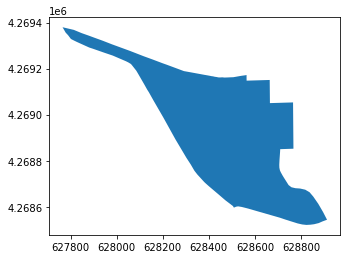

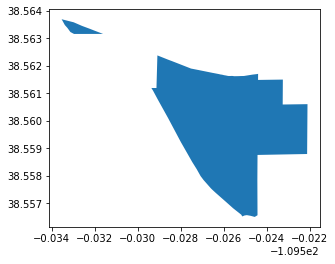

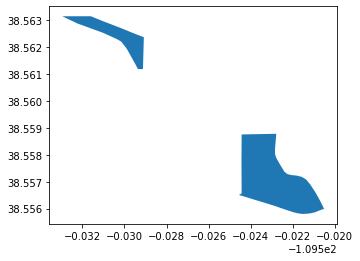

In [270]:
ut_vest[ut_vest['joinid'] == '10-02:70'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '10-02:470'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '10-02:570'].plot()

<AxesSubplot:>

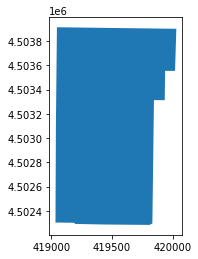

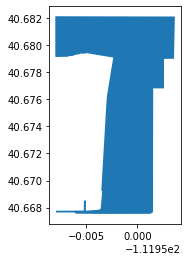

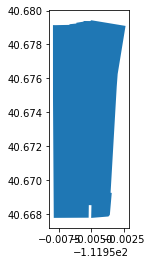

In [271]:
ut_vest[ut_vest['joinid'] == '18-TAY001'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-TAY001:01'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-TAY001:90'].plot()

<AxesSubplot:>

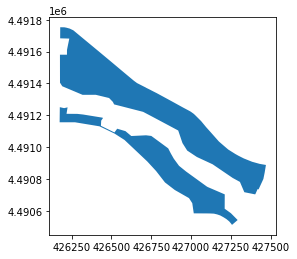

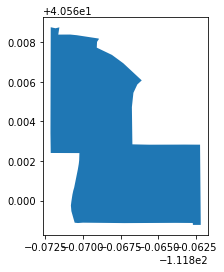

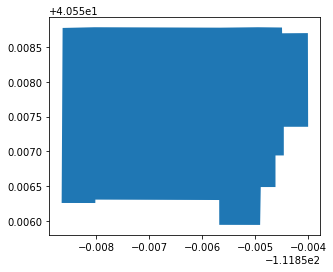

In [272]:
ut_vest[ut_vest['joinid'] == '18-WHT005'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-WHT004:00'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '18-WHT003:02'].plot()


<AxesSubplot:>

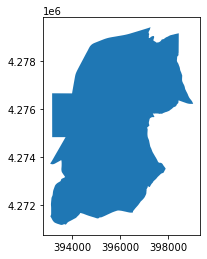

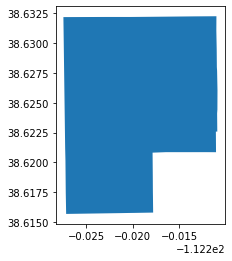

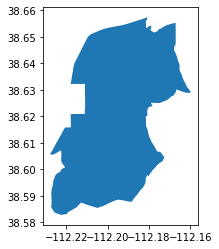

In [273]:
ut_vest[ut_vest['joinid'] == '21-7.1.3'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '21-7:1'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '21-7:3'].plot()


<AxesSubplot:>

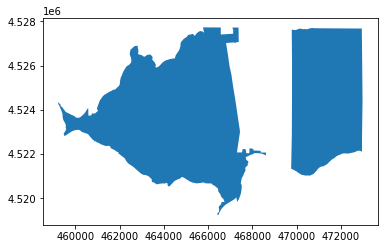

In [274]:
ut_vest[ut_vest['joinid'] == '22-HOYT18uninc'].plot()


<AxesSubplot:>

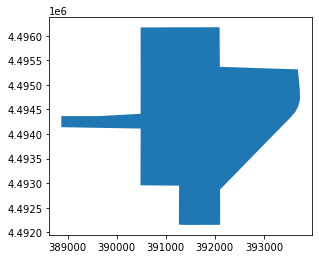

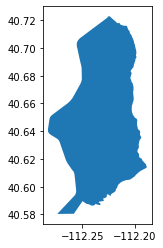

In [275]:
ut_vest[ut_vest['joinid'] == '23-ERD-02:1'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '23-ERD-12:0'].plot()

<AxesSubplot:>

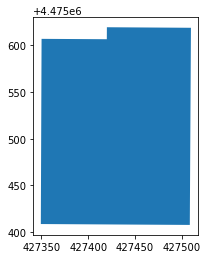

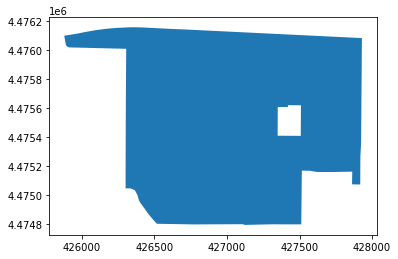

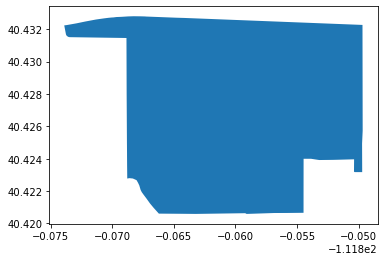

In [276]:
ut_vest[ut_vest['joinid'] == '25-LE12:UN'].plot()
ut_vest[ut_vest['joinid'] == '25-LE12'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '25-LE12'].plot()

<AxesSubplot:>

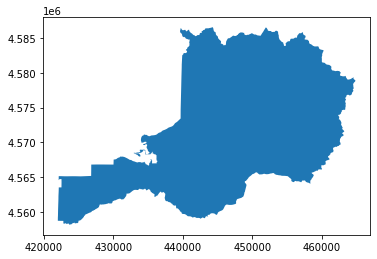

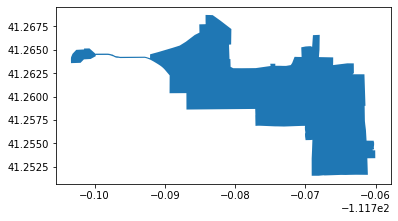

In [277]:
ut_vest[ut_vest['joinid'] == '29-HTV002'].plot()
combo_precinct_vista[combo_precinct_vista['joinid'] == '29-HTV001:R'].plot()

<AxesSubplot:>

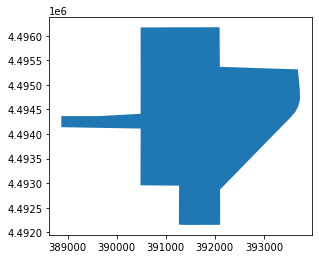

In [278]:
ut_vest[ut_vest['joinid'] == '23-ERD-02:1'].plot()
#combo_precinct_vista[combo_precinct_vista['joinid'] == '23-ERD-02:0'].plot()

In [279]:
geo_list = pd.read_csv('geo_dict.csv')
geo_dict = dict(zip(geo_list["source"],geo_list["vest"]))
display(geo_dict)

{'5-1001:DS1': '5-1001:DS1,SD1',
 '5-1001:SD1': '5-1001:DS1,SD1',
 '5-1001:SD2': '5-1001:DS2,SD2',
 '5-1001:DS2': '5-1001:DS2,SD2',
 '5-1002:MS3': '5-1002:MS3,SD3',
 '6-CF01:I-N-': '6-CF01',
 '7-RO92': '7-R092',
 '10-01:470': '10-01:70',
 '10-01:570': '10-01:70',
 '10-02:569': '10-02:69',
 '10-02:570': '10-02:70',
 '10-02:470': '10-02:70',
 '10-03:570': '10-03:70',
 '10-03:470': '10-03:70',
 '10-04:569': '10-04:69',
 '10-04:470': '10-04:70',
 '10-04:570': '10-04:70',
 '10-05:569': '10-05:69',
 '10-05:470': '10-05:70',
 '10-05:570': '10-05:70',
 '10-06:469': '10-06:69',
 '10-06:569': '10-06:69',
 '10-06:470': '10-06:70',
 '10-06:570': '10-06:70',
 '10-07:569': '10-07:69',
 '10-07:570': '10-07:70',
 '10-08:469': '10-08:69',
 '10-08:569': '10-08:69',
 '10-09:569': '10-09:69',
 '10-09:470': '10-09:70',
 '10-09:570': '10-09:70',
 '10-10:470': '10-10:70',
 '10-10:570': '10-10:70',
 '10-11:469': '10-11:69',
 '10-11:569': '10-11:69',
 '10-11:470': '10-11:70',
 '10-11:570': '10-11:70',
 '15-10:

In [280]:
del geo_dict['not found']

In [281]:
combo_precinct_vista_copy = combo_precinct_vista
combo_precinct_vista_copy["joinid"] = combo_precinct_vista_copy["joinid"].map(geo_dict).fillna(combo_precinct_vista_copy["joinid"])
display(combo_precinct_vista_copy)
dissolved_geo = combo_precinct_vista_copy.dissolve(by='joinid')
display(dissolved_geo)

,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,joinid
0,1,13,BW,BW,None,None,2012-01-01,None,kanerds,2012-02-02,{F856988C-74CA-415D-AC4B-2A2020023EC9},0.195803,0.001577,"POLYGON ((-111.65149 37.09008, -111.65157 37.0...",13-BW
1,2,25,OR20,OR20,None,2021.1,2021-03-02,None,AndreaB,2021-03-02,{893A863C-A9DA-4214-8E4D-11FF587BCFBB},0.044090,0.000095,"POLYGON ((-111.70145 40.31183, -111.70274 40.3...",25-OR20
2,3,18,SLC117:00,SLC117,00,None,2019-12-16,Salt Lake City,None,2019-12-16,{30563DA7-3B62-427D-A0A5-1460FC75243B},0.039456,0.000041,"POLYGON ((-111.83496 40.74981, -111.83440 40.7...",18-SLC117:00
3,4,27,COHV28,COHV28,None,None,2012-01-01,None,nancy.lucchetti,2019-02-25,{BF88FEB3-58B4-4952-AE30-9BAE88CFB519},2.571008,0.063659,"POLYGON ((-113.26559 37.19438, -113.26488 37.1...",27-COHV28
4,5,18,COT004:02,COT004,02,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{F45718CC-DFFA-4FAD-9BF8-7081A6F4E942},0.024309,0.000026,"POLYGON ((-111.82472 40.63447, -111.82475 40.6...",18-COT004:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3043,29,PLC002:B,PLC002,B,None,2021-02-22,None,None,2021-02-22,{D2A4DB59-F3AF-4B70-A6CB-D91C853A732F},0.234410,0.000769,"MULTIPOLYGON (((-112.05876 41.33589, -112.0589...",29-PLC002:B
3043,3044,18,TAY041:00,TAY041,00,None,2019-12-16,Taylorsville,None,2019-12-16,{C8BAAF11-5436-49CD-8A9F-2FBCF5CEBDED},0.036616,0.000062,"POLYGON ((-111.93201 40.64322, -111.93195 40.6...",18-TAY041:00
3044,3045,18,MIL032:01,MIL032,01,None,2019-12-16,Millcreek,None,2019-12-16,{97F6DDC2-7C48-4874-88F2-A363691EF564},0.060945,0.000100,"POLYGON ((-111.81371 40.71131, -111.81371 40.7...",18-MIL032:01
3045,3046,18,COT038:00,COT038,00,None,2019-12-16,Cottonwood Heights,None,2019-12-16,{CFB98657-4740-4B53-A6FF-BB69FE5CD0EB},0.045916,0.000078,"POLYGON ((-111.78793 40.58628, -111.78788 40.5...",18-COT038:00


,geometry,OBJECTID,CountyID,VistaID,PrecinctID,SubPrecinc,VersionNbr,EffectiveD,AliasName,Comments,RcvdDate,GlobalID,SHAPE_Leng,SHAPE_Area
joinid,,,,,,,,,,,,,,
1-BV01:1,"POLYGON ((-112.61943 38.28272, -112.61932 38.2...",116,1,BV01:1,BV01,1,2013-1,2012-01-01,None,None,2013-10-16,{0FA59E15-AE99-4036-BAC2-9B52BD96C41E},0.078745,0.000202
1-BV02:1,"POLYGON ((-112.64838 38.30108, -112.63701 38.3...",1061,1,BV02:1,BV02,1,2013-1,2012-01-01,None,None,2013-10-16,{42E04D64-AB96-467C-8CA7-9C6CCB6BDC3C},0.226984,0.000838
1-BV03:1,"MULTIPOLYGON (((-112.65342 38.22070, -112.6533...",1017,1,BV03:1,BV03,1,2013-1,2013-10-16,None,None,2013-10-16,{1C4CBC52-7A01-4F50-AB5B-F3FC2BEB34A6},0.323054,0.000728
1-BV03:2,"MULTIPOLYGON (((-112.62208 38.31248, -112.6215...",420,1,BV03:2,BV03,2,2013-1,2013-10-16,None,None,2013-10-16,{D02BB6DB-1A3E-4369-BC75-7B0AE02820FE},2.428363,0.077798
1-BV04:1,"POLYGON ((-112.51533 38.50140, -112.51560 38.5...",2966,1,BV04:1,BV04,1,2013-1,2012-01-01,None,None,2013-10-16,{A9ECB9F0-C95B-497D-A358-C9CB6664DBE9},1.435445,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-PA8:1,"POLYGON ((-112.44624 37.81799, -112.45084 37.8...",855,9,PA8:1,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{636E5665-1302-47E1-939F-401CA0E16883},0.118368,0.000351
9-PA8:2,"POLYGON ((-112.44624 37.81799, -112.44272 37.8...",913,9,PA8:2,PA8,None,None,None,None,initial estimate by AGRC,2011-07-12,{D253077A-9D44-4537-B029-6246F8D8051D},1.826924,0.069706
9-TI9:1,"POLYGON ((-110.20313 37.94548, -110.20329 37.9...",1059,9,TI9:1,TI9,1,None,2012-01-01,None,initial estimate by AGRC,2011-07-12,{D8704BC5-234B-4139-80C1-D03372242AE0},3.416384,0.407979


In [282]:
left_only_geo2_copy = left_only_geo2.drop(columns = ['_merge','OBJECTID','CountyID','VistaID','PrecinctID','SubPrecinc','VersionNbr','EffectiveD','AliasName','Comments','RcvdDate','GlobalID','SHAPE_Leng','SHAPE_Area','geometry','_merge'])
print(len(left_only_geo2_copy))
print(len(dissolved_geo))
join_attempt_geo3 = pd.merge(left_only_geo2_copy, dissolved_geo, how="outer",on="joinid",indicator=True)
print(join_attempt_geo3["_merge"].value_counts())

merged_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="both"]
right_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="right_only"]
right_only_geo3_sorted = right_only_geo3.sort_values('joinid')
left_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="left_only"]

left_only_geo3.to_csv("./only_vest_geo3.csv")
#right_only_geo3_sorted.to_csv("./only_source_geo2.csv")



84
2887
right_only    2819
both            68
left_only       16
Name: _merge, dtype: int64


In [283]:
ut_geo_sorted = ut_geo
ut_geo_sorted['joinid'] = ut_geo_sorted['CountyID'].astype(str) + '-' + ut_geo_sorted['VistaID']
ut_geo_sorted = ut_geo_sorted.sort_values('joinid')
ut_geo_sorted.to_csv("./ut_geo.csv")


In [284]:
#print(merged_geo)
#print(merged_geo2)
#print(merged_geo3)

merged_geo_clean = merged_geo.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','totals','OBJECTID','VistaID'])
merged_geo2_clean = merged_geo2.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','OBJECTID','VistaID', 'PrecinctID'])
merged_geo3_clean = merged_geo3.drop(columns = ['SubPrecinc', 'VersionNbr', 'EffectiveD', 'AliasName','Comments','RcvdDate', 'GlobalID', '_merge','SHAPE_Leng','SHAPE_Area','OBJECTID','VistaID', 'PrecinctID'])

merged_geo2_clean.rename(columns = {"CountyID": "CountyID_y",
                                   "geometry": "geometry_y"}, 
          inplace = True)
merged_geo3_clean.rename(columns = {"CountyID": "CountyID_y",
                                   "geometry": "geometry_y"}, 
          inplace = True)

display(merged_geo_clean)
display(merged_geo2_clean)
display(merged_geo3_clean)


merged_df = (pd.concat([merged_geo_clean, merged_geo2_clean, merged_geo3_clean])).reset_index()
merged_df.drop(columns = 'index', inplace= True)
merged_df.to_csv("./merged_df.csv")

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
1,29.0,FRW001,29-FRW001,476.0,79.0,3.0,11.0,18.0,1.0,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,"POLYGON ((-112.00880 41.29063, -112.00853 41.2...",29.0
2,29.0,FRW002,29-FRW002,304.0,132.0,5.0,12.0,24.0,1.0,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,"POLYGON ((-112.02584 41.28957, -112.02584 41.2...",29.0
3,29.0,FRW003,29-FRW003,583.0,129.0,11.0,29.0,24.0,3.0,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,"POLYGON ((-112.04305 41.31013, -112.04305 41.3...",29.0
4,29.0,FRW004,29-FRW004,652.0,143.0,12.0,35.0,32.0,2.0,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,"POLYGON ((-112.04482 41.33610, -112.04482 41.3...",29.0
5,29.0,HPR001,29-HPR001,454.0,82.0,10.0,14.0,21.0,2.0,"POLYGON ((405841.300 4563000.630, 405934.010 4...",29-HPR001,21,82,10,14,2,454,"POLYGON ((-112.10285 41.18622, -112.10286 41.1...",29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,27.0,SGAIR,27-SGAIR,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((277885.930 4102780.480, 277884.100 4...",27-SGAIR,0,0,0,0,0,0,"POLYGON ((-113.49760 37.04499, -113.49762 37.0...",27.0
2326,8.0,2,8-2,307.0,32.0,16.0,6.0,7.0,1.0,"POLYGON ((475013.780 4333510.100, 475021.040 4...",8-2,7,32,16,6,1,308,"MULTIPOLYGON (((-109.31906 37.85842, -109.3191...",8.0
2329,8.0,10,8-10,297.0,43.0,11.0,10.0,6.0,0.0,"POLYGON ((513729.810 4356924.450, 514735.170 4...",8-10,6,43,11,10,0,297,"MULTIPOLYGON (((-109.69054 37.21803, -109.6898...",8.0
2332,8.0,4,8-4,80.0,12.0,5.0,2.0,5.0,0.0,"POLYGON ((488533.070 4341053.710, 488523.300 4...",8-4,5,12,5,2,0,81,"MULTIPOLYGON (((-109.47352 37.63285, -109.4736...",8.0


,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,CountyID_y,geometry_y
2,29.0,RIV002,29-RIV002,340.0,209.0,10.0,15.0,17.0,0.0,"POLYGON ((417711.180 4560608.420, 417713.140 4...",29-RIV002,17,209,10,15,0,340,29.0,"POLYGON ((-111.98131 41.19266, -111.98129 41.1..."
3,29.0,RIV003,29-RIV003,338.0,175.0,6.0,27.0,27.0,3.0,"POLYGON ((415896.380 4560210.520, 415922.730 4...",29-RIV003,27,175,6,27,3,338,29.0,"POLYGON ((-112.00258 41.18885, -112.00195 41.1..."
9,3.0,LOG01:CSD,3-LOG01:CSD,42.0,44.0,1.0,3.0,1.0,0.0,"POLYGON ((430971.240 4619310.810, 430995.300 4...",3-LOG01:CSD,1,44,1,3,0,42,3.0,"POLYGON ((-111.82992 41.72261, -111.82963 41.7..."
10,3.0,LOG01:I,3-LOG01:I,114.0,104.0,8.0,10.0,4.0,0.0,"POLYGON ((431191.910 4620064.060, 431184.290 4...",3-LOG01:I,4,104,8,10,0,114,3.0,"POLYGON ((-111.82735 41.72941, -111.82742 41.7..."
11,3.0,LOG27:17C,3-LOG27:17C,1.0,0.0,0.0,0.0,2.0,0.0,"MULTIPOLYGON (((427048.990 4614431.440, 427059...",3-LOG27:17C,2,0,0,0,0,1,3.0,"MULTIPOLYGON (((-111.87647 41.67832, -111.8763..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,26.0,55:1,26-55:1,154.0,69.0,0.0,4.0,7.0,1.0,"POLYGON ((461224.270 4481329.260, 461224.280 4...",26-55:1,7,69,0,4,1,154,26.0,"POLYGON ((-111.45750 40.48175, -111.45750 40.4..."
291,12.0,NE03:5,12-NE03:5,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((345796.490 4394130.360, 363449.220 4...",12-NE03:5,0,0,0,0,0,0,12.0,"POLYGON ((-112.79819 39.68310, -112.59235 39.6..."
292,17.0,UNINH,17-UNINH,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((476910.860 4643876.500, 476898.550 4...",17-UNINH,0,0,0,0,0,0,17.0,"POLYGON ((-111.27857 41.94653, -111.27871 41.9..."
293,25.0,SR09:UN,25-SR09:UN,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((421380.630 4464308.450, 421371.490 4...",25-SR09:UN,0,0,0,0,0,0,25.0,"POLYGON ((-111.92545 40.32561, -111.92546 40.3..."


,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
7,5.0,"1001:DS1,SD1","5-1001:DS1,SD1",46.0,22.0,0.0,1.0,0.0,0.0,"POLYGON ((664004.500 4540665.600, 664047.300 4...","5-1001:DS1,SD1",0,22,0,1,0,46,"POLYGON ((-109.47020 40.75565, -109.47007 40.7...",5.0
8,5.0,"1001:DS2,SD2","5-1001:DS2,SD2",28.0,6.0,0.0,0.0,0.0,0.0,"POLYGON ((631806.960 4539575.320, 631790.700 4...","5-1001:DS2,SD2",0,6,0,0,0,28,"POLYGON ((-109.43310 40.99575, -109.43315 40.9...",5.0
9,5.0,"1002:MS3,SD3","5-1002:MS3,SD3",67.0,9.0,0.0,3.0,4.0,0.0,"POLYGON ((607236.150 4538845.570, 607237.900 4...","5-1002:MS3,SD3",4,9,0,3,0,67,"POLYGON ((-109.72507 40.99375, -109.72505 40.9...",5.0
10,6.0,CF01,6-CF01,317.0,134.0,11.0,12.0,22.0,0.0,"POLYGON ((416489.110 4549534.150, 416489.350 4...",6-CF01,22,134,11,12,0,317,"POLYGON ((-112.00419 41.10354, -112.00189 41.1...",6.0
11,7.0,R092,7-R092,53.0,4.0,2.0,2.0,4.0,0.0,"MULTIPOLYGON (((582229.870 4461736.360, 582232...",7-R092,4,4,2,2,0,53,"MULTIPOLYGON (((-110.05909 40.27309, -110.0596...",7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8.0,7,8-7,269.0,45.0,6.0,8.0,6.0,1.0,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,"POLYGON ((-110.98388 39.26838, -110.98381 39.2...",8.0
80,8.0,6,8-6,222.0,39.0,14.0,4.0,5.0,0.0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,"POLYGON ((-111.02013 39.23149, -111.01997 39.2...",8.0
81,8.0,1,8-1,109.0,16.0,7.0,2.0,5.0,0.0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,"POLYGON ((-110.98149 39.04336, -110.98075 39.0...",8.0
82,8.0,12,8-12,239.0,58.0,10.0,4.0,14.0,1.0,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,13,58,10,4,1,238,"POLYGON ((-110.16173 38.97990, -110.16274 38.9...",8.0


In [285]:
display(merged_df[merged_df['joinid'] == '12-NE02:5'])

display(merged_df)

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
2107,12.0,NE02:5,12-NE02:5,123.0,9.0,1.0,0.0,1.0,3.0,"POLYGON ((428643.160 4394758.930, 428643.150 4...",12-NE02:5,3,1,0,1,123000000,9,"POLYGON ((-111.83233 39.69971, -111.83233 39.6...",12.0


,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
0,29.0,FRW001,29-FRW001,476.0,79.0,3.0,11.0,18.0,1.0,"POLYGON ((415532.900 4571511.100, 415555.020 4...",29-FRW001,18,79,3,11,1,476,"POLYGON ((-112.00880 41.29063, -112.00853 41.2...",29.0
1,29.0,FRW002,29-FRW002,304.0,132.0,5.0,12.0,24.0,1.0,"POLYGON ((414104.540 4571410.010, 414104.310 4...",29-FRW002,24,132,5,12,1,304,"POLYGON ((-112.02584 41.28957, -112.02584 41.2...",29.0
2,29.0,FRW003,29-FRW003,583.0,129.0,11.0,29.0,24.0,3.0,"POLYGON ((412691.000 4573709.660, 412690.930 4...",29-FRW003,24,129,11,29,3,583,"POLYGON ((-112.04305 41.31013, -112.04305 41.3...",29.0
3,29.0,FRW004,29-FRW004,652.0,143.0,12.0,35.0,32.0,2.0,"POLYGON ((413427.540 4576634.630, 413436.480 4...",29-FRW004,32,143,12,35,2,652,"POLYGON ((-112.04482 41.33610, -112.04482 41.3...",29.0
4,29.0,HPR001,29-HPR001,454.0,82.0,10.0,14.0,21.0,2.0,"POLYGON ((405841.300 4563000.630, 405934.010 4...",29-HPR001,21,82,10,14,2,454,"POLYGON ((-112.10285 41.18622, -112.10286 41.1...",29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,8.0,7,8-7,269.0,45.0,6.0,8.0,6.0,1.0,"POLYGON ((501365.550 4346591.320, 501391.780 4...",8-7,6,45,6,8,1,269,"POLYGON ((-110.98388 39.26838, -110.98381 39.2...",8.0
2348,8.0,6,8-6,222.0,39.0,14.0,4.0,5.0,0.0,"POLYGON ((492711.790 4352877.890, 493623.880 4...",8-6,5,39,14,4,0,222,"POLYGON ((-111.02013 39.23149, -111.01997 39.2...",8.0
2349,8.0,1,8-1,109.0,16.0,7.0,2.0,5.0,0.0,"POLYGON ((501830.210 4321591.850, 501840.430 4...",8-1,5,16,7,2,0,109,"POLYGON ((-110.98149 39.04336, -110.98075 39.0...",8.0
2350,8.0,12,8-12,239.0,58.0,10.0,4.0,14.0,1.0,"POLYGON ((583943.480 4369273.120, 583916.090 4...",8-12,13,58,10,4,1,238,"POLYGON ((-110.16173 38.97990, -110.16274 38.9...",8.0


In [286]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["joinid"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["joinid"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["joinid"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [287]:
races = ['G18USSCAAL','G18USSDWIL','G18USSIMCC','G18USSLBOW','G18USSOWRI','G18USSRROM']

display(merged_df[merged_df['joinid'] == '12-NE02:5'])

merged_df = merged_df.astype({'G18USSCAAL_x':int,'G18USSDWIL_x':int,'G18USSIMCC_x':int,'G18USSLBOW_x':int,'G18USSOWRI_x':int,'G18USSRROM_x':int,
                             'G18USSCAAL_y':int,'G18USSDWIL_y':int,'G18USSIMCC_y':int,'G18USSLBOW_y':int,'G18USSOWRI_y':int,'G18USSRROM_y':int,
                             })
validater_row(merged_df.sort_values("joinid"),races)

,CountyID_x,mergeid,uniqueid,G18USSRROM_x,G18USSDWIL_x,G18USSIMCC_x,G18USSLBOW_x,G18USSCAAL_x,G18USSOWRI_x,geometry_x,joinid,G18USSCAAL_y,G18USSDWIL_y,G18USSIMCC_y,G18USSLBOW_y,G18USSOWRI_y,G18USSRROM_y,geometry_y,CountyID_y
2107,12.0,NE02:5,12-NE02:5,123.0,9.0,1.0,0.0,1.0,3.0,"POLYGON ((428643.160 4394758.930, 428643.150 4...",12-NE02:5,3,1,0,1,123000000,9,"POLYGON ((-111.83233 39.69971, -111.83233 39.6...",12.0


G18USSCAAL ...............................................................12-NE02:5 (V) ....1  (S)....3 (D):    2
G18USSDWIL ...............................................................12-NE02:5 (V) ....9  (S)....1 (D):   -8
G18USSIMCC ...............................................................12-NE02:5 (V) ....1  (S)....0 (D):   -1
G18USSLBOW ...............................................................12-NE02:5 (V) ....0  (S)....1 (D):    1
G18USSOWRI ...............................................................12-NE02:5 (V) ....3  (S)123000000 (D):122999997
G18USSRROM ...............................................................12-NE02:5 (V) ..123  (S)....9 (D): -114
G18USSOWRI ...............................................................18-BLF003 (V) ....3  (S)30000000 (D):29999997
G18USSOWRI ...............................................................18-BLF006 (V) ....4  (S)40000000 (D):39999996
G18USSOWRI .........................................................

In [294]:
source_geoms = gp.GeoDataFrame(merged_df,geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(merged_df,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2352
dtype: int64


1) For 4-34 difference in area is 358.3921306894557
2) For 5-1002 difference in area is 10.126471528201314
3) For 6-CE11 difference in area is 9.299069606546952
4) For 18-HER015 difference in area is 1.937802247864348
5) For 19-3 difference in area is 304.02872429924844
6) For 19-6 difference in area is 30.397758549099404
7) For 19-7 difference in area is 115.2641339405628
8) For 19-9 difference in area is 211.5527243119356
9) For 21-11 difference in area is 1880.4685283314946
10) For 21-13 difference in area is 1240.8759649430112
11) For 21-14 difference in area is 25.477502526484297
12) For 21-15 difference in area is 121.5374803151656
13) For 21-20 difference in area is 6.969072063064679
14) For 21-22 difference in area is 391.40452905575563
15) For 21-23 difference in area is 1.4065173552179204
16) For 21-24 difference in area is 10.22769355547244
17) For 22-CCRK20 difference in area is 1.3312002928899473
18) For 22-COAL19 difference in area is 1.2969694771383247
19) For 22-HOYT18 

/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For 25-SA02 difference in area is 5.332786193602879
23) For 25-SF02 difference in area is 1.122316716916649
24) For 25-SF07 difference in area is 5.009963329861524
25) For 25-SP04 difference in area is 1.7669634919207788
26) For 25-SP07 difference in area is 61.17927585505121
27) For 25-SQ01 difference in area is 1.1664649608928614
28) For 25-SQ02 difference in area is 1.1126341462858318
29) For 25-SQ03 difference in area is 12.890196249436993
30) For 25-SQ04 difference in area is 3.0573566673491754
31) For 25-SR09 difference in area is 2.9904088847599124
32) For 25-SR10 difference in area is 4.448878690796193
33) For 26-12 difference in area is 219.4356072184908
34) For 26-30 difference in area is 2.170870425676296
35) For 26-32 difference in area is 13.772488529372081
36) For 26-33 difference in area is 1.7231758433933648
37) For 26-40 difference in area is 9.915883099826553
38) For 26-43 difference in area is 1.4744644264475368
39) For 26-54 difference in area is 2.4198994050805

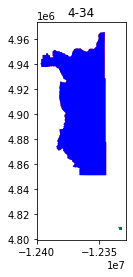

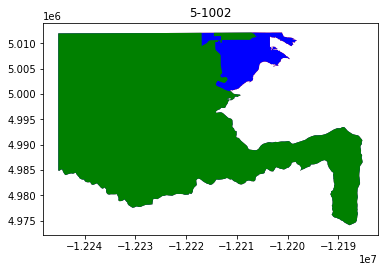

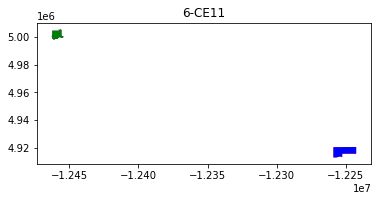

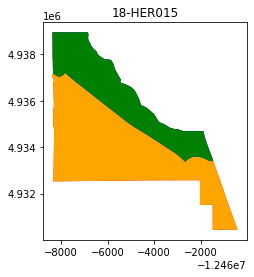

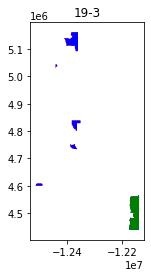

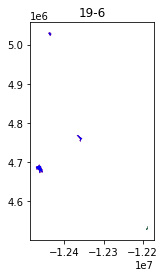

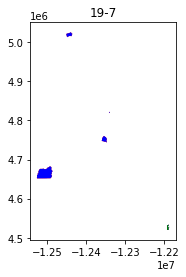

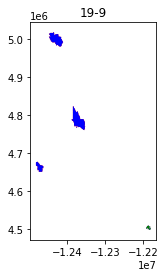

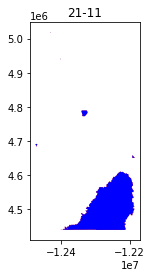

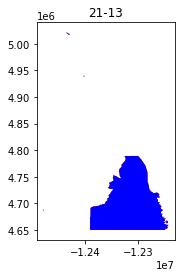

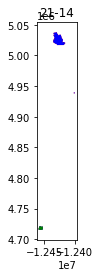

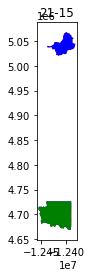

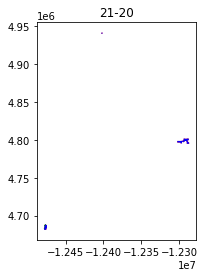

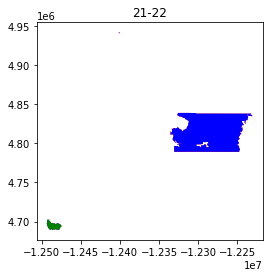

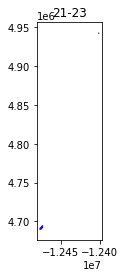

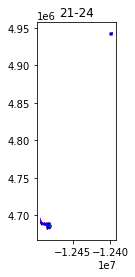

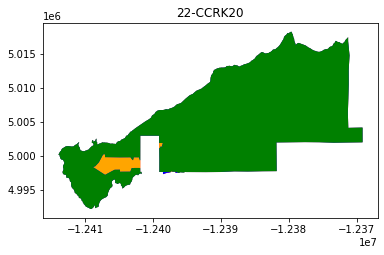

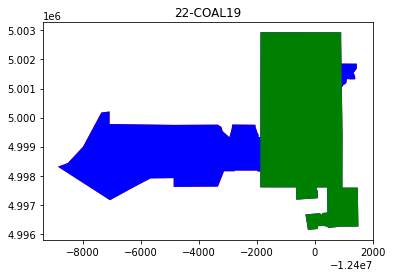

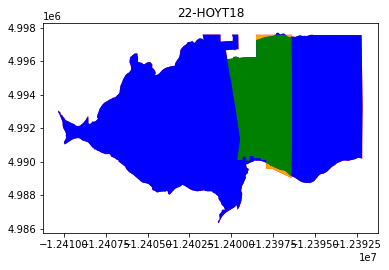

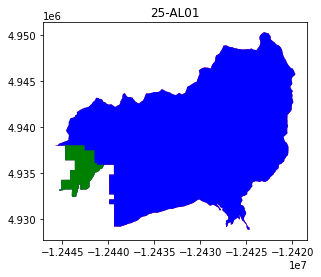

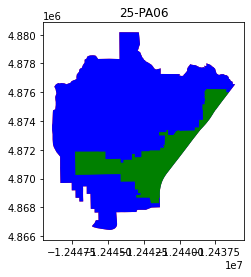

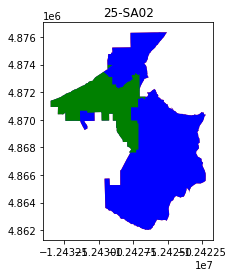

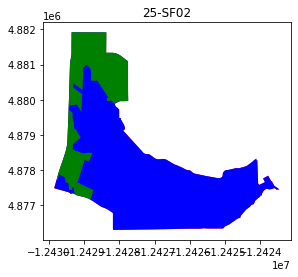

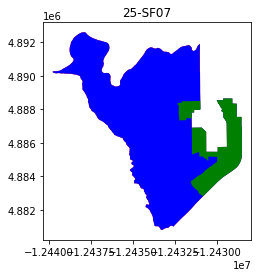

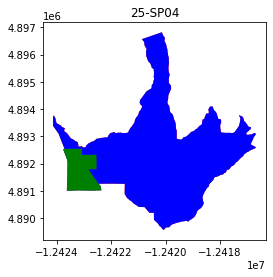

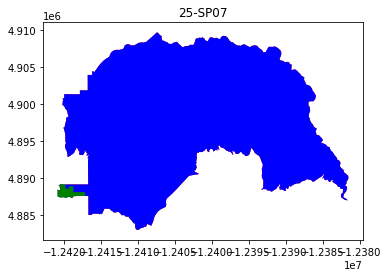

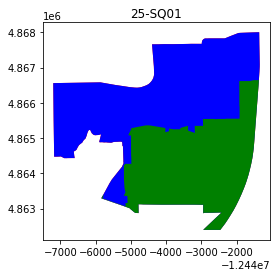

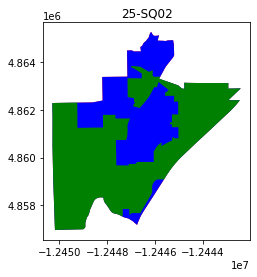

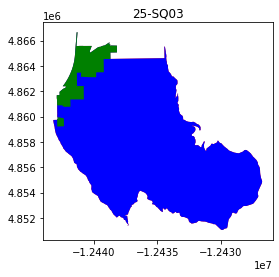

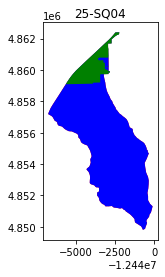

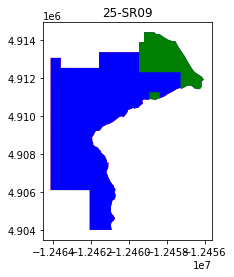

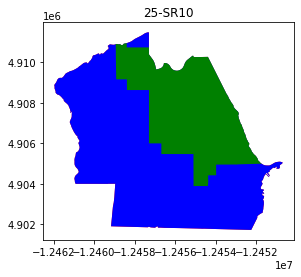

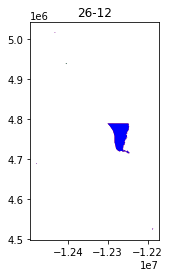

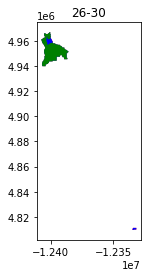

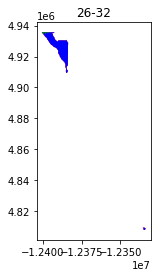

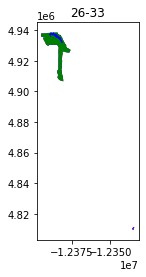

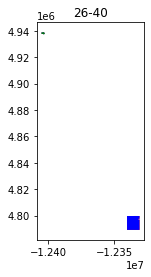

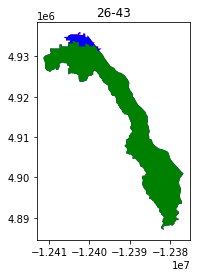

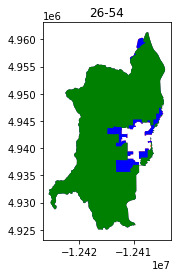

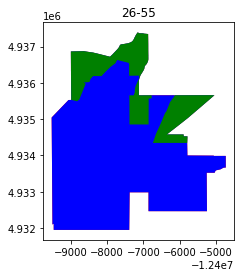

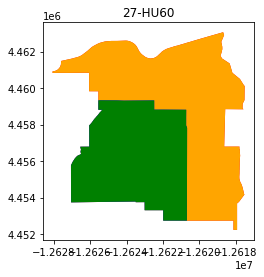

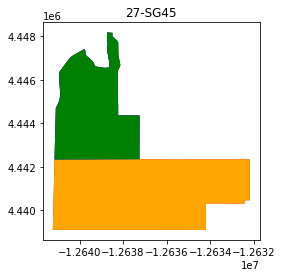

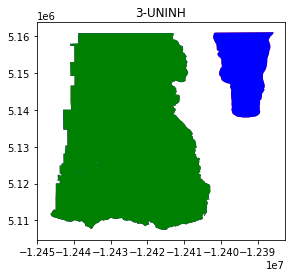

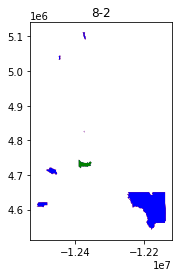

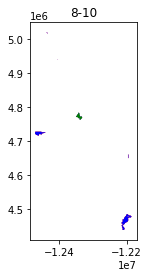

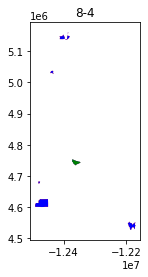

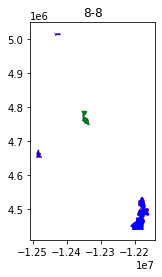

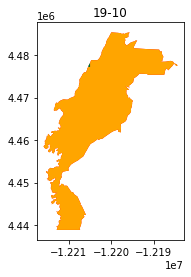

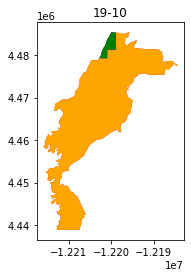

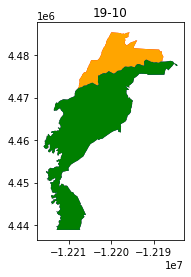

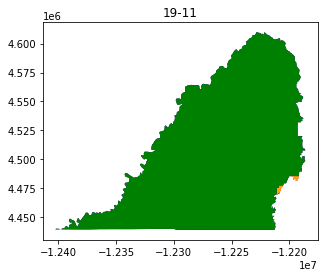

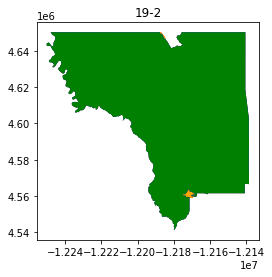

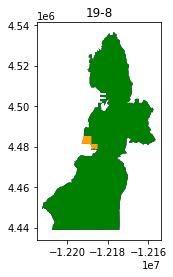

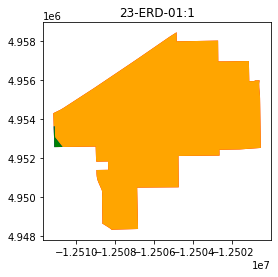

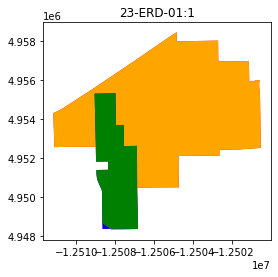

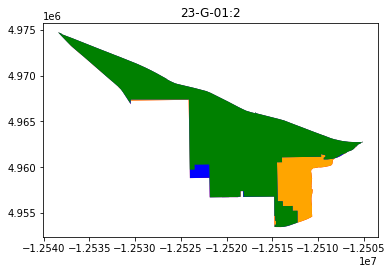

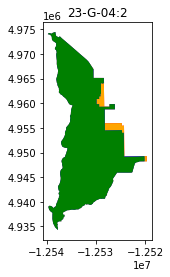

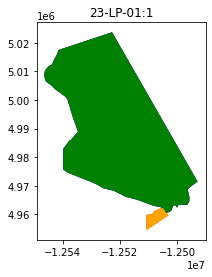

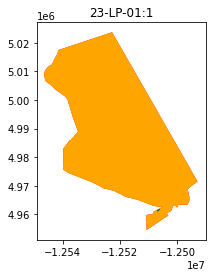

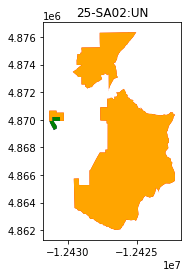

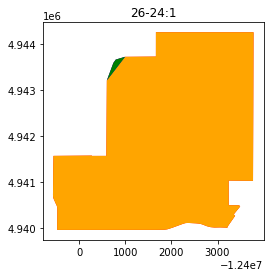

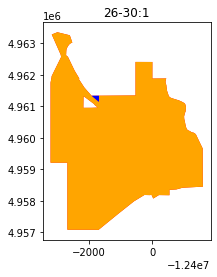

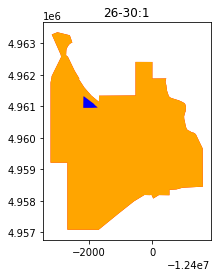

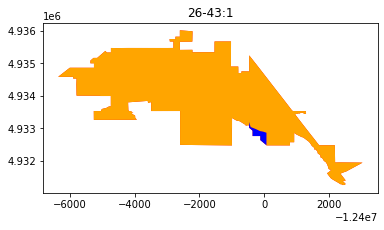

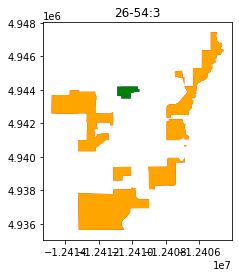

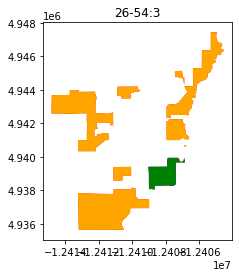

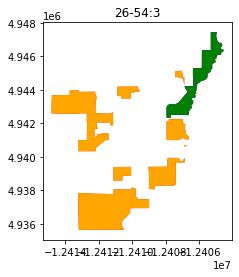

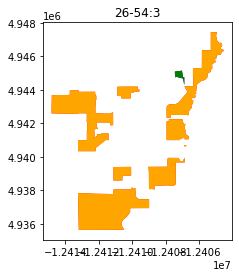

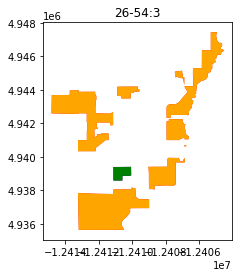

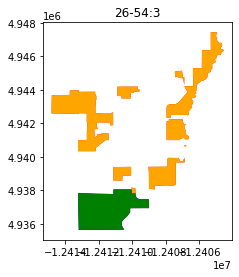

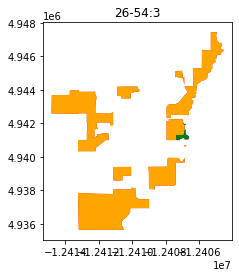

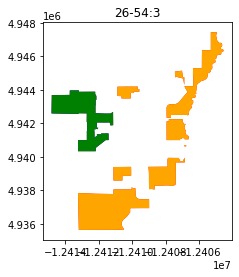

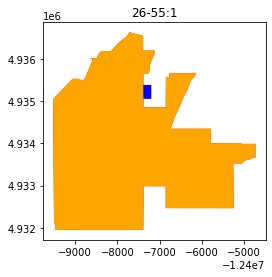

In [296]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"joinid"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [297]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2352, 1)
0 precincts w/ a difference of 0 km^2
2176 precincts w/ a difference between 0 and .1 km^2
91 precincts w/ a difference between .1 and .5 km^2
12 precincts w/ a difference between .5 and 1 km^2
21 precincts w/ a difference between 1 and 2 km^2
17 precincts w/ a difference between 2 and 5 km^2
35 precincts w/ a difference greater than 5 km^2
